# gurobiによる制約最適化を行う

In [160]:
import math
import random
import networkx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import networkx
from gurobipy import *

## 変数
- $x_{ik}$ $x_{jl}$ : 人iが避難施設kに避難した場合に１　バイナリー変数

## 定数

- $D_{kl}$ : 避難施設kとlの間に定義される伝染危険率
    - 二つの距離が近いと大きい

- $W_{ij} $ : 人i,jでの伝染危険率(以下の二つの重み付き自乗和)

    - 感染の差の自乗とmax(jの感染率 – iの感染率,0)・iの死亡率 + max(iの感染率 – jの感染率,0)・ jの死亡率
    - 感染率の差の自乗和

## 目的関数
-  min $\sum_{ijkl}^{} W_{ij} D_{kl}  x_{ik}  x_{jl}$


## 制約
- すべての人 iに対して，x[i,k]の施設kに対する合計 = 1   

- 施設kに対してx[i]=kの人に対する合計が施設kの容量以下

## 必要な集合
- 人の集合 people
- 人の感染率の集合 infec_rate
- 人の死亡率の集合 mort_rate
- 施設集合 shelters
- 施設の位置情報 locations
- 施設の容量 capacity

In [161]:
random.seed(1)

In [162]:
N = 10 #人の数
people = [i for i in range(N)] #人の集合
infec_rate,mort_rate = {},{}
for i in people:
    infec_rate[i] = random.randint(0,100)/100
    mort_rate[i] = random.randint(0,100)/100
print(infec_rate)
print(mort_rate)

{0: 0.17, 1: 0.97, 2: 0.32, 3: 0.63, 4: 0.57, 5: 0.83, 6: 1.0, 7: 0.12, 8: 0.03, 9: 0.55}
{0: 0.72, 1: 0.08, 2: 0.15, 3: 0.97, 4: 0.6, 5: 0.48, 6: 0.26, 7: 0.62, 8: 0.49, 9: 0.77}


In [163]:
N_s = 5
shelters = [i for i in range(N_s)] #施設の集合
capacity = {}
for i in shelters:
    capacity[i] = random.randint(1,3)
locations= np.random.rand(N_s, 2) * 100
print(locations)
print(capacity)

[[94.9357958  21.97815132]
 [83.97863289 94.99074948]
 [89.75592357 61.43564059]
 [81.26349128 14.45347096]
 [19.39632252 38.40249847]]
{0: 1, 1: 3, 2: 2, 3: 2, 4: 3}


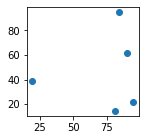

In [164]:
plt.figure(figsize=(2, 2))
plt.plot(locations[:, 0], locations[:, 1], 'o')
plt.show()

In [165]:
#D[k,l]施設間の感染率　簡易的に距離で置いている 反比例
x_y = np.array(locations)
x = x_y[:, 0]
y = x_y[:, 1]
#D = np.sqrt((x[:, np.newaxis] - x[np.newaxis, :]) ** 2 +(y[:, np.newaxis] - y[np.newaxis, :]) ** 2)

In [166]:
D = np.zeros((N_s,N_s))
for i in shelters:
    for j in shelters:
        if i == j:
            D[i,j] = 1
D

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [167]:
#W[i,j]
W = np.zeros((N,N))
for i in people:
    for j in people:
        w1 = max(infec_rate[j] - infec_rate[i],0) * mort_rate[i] + max(infec_rate[i] - infec_rate[j],0) * mort_rate[j]
        w2 = (infec_rate[j] - infec_rate[i]) ** 2
        W[i,j] = w1*w2
W

array([[0.0000000e+00, 3.6864000e-01, 2.4300000e-03, 7.0081920e-02,
        4.6080000e-02, 2.0699712e-01, 4.1168664e-01, 7.7500000e-05,
        1.3445600e-03, 3.9507840e-02],
       [3.6864000e-01, 0.0000000e+00, 4.1193750e-02, 3.8124880e-02,
        3.8400000e-02, 1.3171200e-03, 2.1600000e-06, 3.8075750e-01,
        4.0698616e-01, 5.7047760e-02],
       [2.4300000e-03, 4.1193750e-02, 0.0000000e+00, 4.4686500e-03,
        2.3437500e-03, 1.9897650e-02, 4.7164800e-02, 4.9600000e-03,
        1.1950610e-02, 1.8250500e-03],
       [7.0081920e-02, 3.8124880e-02, 4.4686500e-03, 0.0000000e+00,
        1.2960000e-04, 7.7600000e-03, 4.9133410e-02, 8.2243620e-02,
        1.0584000e-01, 3.9424000e-04],
       [4.6080000e-02, 3.8400000e-02, 2.3437500e-03, 1.2960000e-04,
        0.0000000e+00, 1.0545600e-02, 4.7704200e-02, 5.6497500e-02,
        7.7157360e-02, 6.1600000e-06],
       [2.0699712e-01, 1.3171200e-03, 1.9897650e-02, 7.7600000e-03,
        1.0545600e-02, 0.0000000e+00, 2.3582400e-03, 2.21

In [168]:
model = Model()

In [169]:
#人iが避難施設kに避難した場合に1になる0-1変数 x[i,k] x[j,l]
x = {}
for i in people:
    for k in shelters:
        x[i,k] = model.addVar(ub=1, vtype="B", name="x(%s,%s)"%(i,k))
        
#for j in people:
#    for l in shelters:
#        x[j,l] = model.addVar(ub=1, vtype="B", name="x(%s,%s)"%(j,l))
        
model.update()

In [170]:
# z[i,k,j,l]という新しい変数をおく
z = {}
for i in people:
    for k in shelters:
        for j in people:
            for l in shelters:
                if j != i: 
                    z[i,k,j,l] = model.addVar(vtype="B",name="z(%s,%s,%s,%s)"%(i,k,j,l))
model.update()

## 制約

In [171]:
# すべての人 iに対して，x[i,k]の施設kに対する合計 = 1   
for i in people:
    model.addConstr(quicksum(x[i,k] for k in shelters)== 1)
    
#すべての施設kに対して，x[i,k] の人に対する合計が施設kの容量以下
for k in shelters:
    model.addConstr(quicksum(x[i,k] for i in people) <= capacity[k])
model.update()

In [172]:
# Z[i,k,j,l]の制約
for i in people:
    for k in shelters:
        for j in people:
            for l in shelters:
                if j != i:
                    model.addConstr(z[i,k,j,l] >= x[i,k] + x[j,l] -1)
model.update()

In [173]:
#目的関数
model.setObjective(quicksum(W[i,j]*D[k,l]*z[i,k,j,l]
                            for i in people
                            for j in people
                            for k in shelters
                            for l in shelters
                            if j!=i), GRB.MINIMIZE)

model.update()

In [174]:
model.params.DualReductions = 0
model.params.LazyConstraints = 1
model.optimize()
#model.Params.Timelimit = 3600

print ("Optimal solution:",model.ObjVal)

Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (mac64)
Optimize a model with 2265 rows, 2300 columns and 6850 nonzeros
Model fingerprint: 0x3ecbed96
Variable types: 0 continuous, 2300 integer (2300 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-06, 4e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 0.7932303
Presolve removed 90 rows and 0 columns
Presolve time: 0.05s
Presolved: 2175 rows, 2300 columns, 6580 nonzeros
Variable types: 0 continuous, 2300 integer (2300 binary)

Root relaxation: objective 0.000000e+00, 81 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000   

In [175]:
#変数の確認
for v in model.getVars():
    if v.X> 0:
        print(v.VarName, v.X)

x(0,1) 1.0
x(1,3) 0.9999999999999999
x(2,2) 1.0
x(3,4) 1.0
x(4,2) 1.1102230246251565e-16
x(4,4) 0.9999999999999999
x(5,0) 1.0
x(6,3) 1.0
x(6,4) 5.551115123125783e-17
x(7,1) 1.0
x(8,1) 1.0
x(9,4) 1.0
z(0,0,1,2) 1.0
z(0,0,1,3) 1.0
z(0,0,1,4) 1.0
z(0,0,2,1) 1.0
z(0,0,2,2) 1.0
z(0,0,2,3) 1.0
z(0,0,2,4) 1.0
z(0,0,3,1) 1.0
z(0,0,3,2) 1.0
z(0,0,3,3) 1.0
z(0,0,3,4) 1.0
z(0,0,4,1) 1.0
z(0,0,4,2) 1.0
z(0,0,4,3) 1.0
z(0,0,4,4) 1.0
z(0,0,5,1) 1.0
z(0,0,5,2) 1.0
z(0,0,5,3) 1.0
z(0,0,5,4) 1.0
z(0,0,6,1) 1.0
z(0,0,7,1) 1.0
z(0,0,7,2) 1.0
z(0,0,7,3) 1.0
z(0,0,7,4) 1.0
z(0,0,8,1) 1.0
z(0,0,8,2) 1.0
z(0,0,8,4) 1.0
z(0,0,9,1) 1.0
z(0,0,9,2) 1.0
z(0,0,9,3) 1.0
z(0,0,9,4) 1.0
z(0,1,1,0) 1.0
z(0,1,1,2) 1.0
z(0,1,1,3) 1.0
z(0,1,1,4) 1.0
z(0,1,2,0) 1.0
z(0,1,2,2) 1.0
z(0,1,2,3) 1.0
z(0,1,2,4) 1.0
z(0,1,3,2) 1.0
z(0,1,3,3) 1.0
z(0,1,3,4) 1.0
z(0,1,4,0) 1.0
z(0,1,4,2) 1.0
z(0,1,4,3) 1.0
z(0,1,4,4) 1.0
z(0,1,5,0) 1.0
z(0,1,5,2) 1.0
z(0,1,5,3) 1.0
z(0,1,5,4) 1.0
z(0,1,6,0) 1.0
z(0,1,6,2) 1.0
z(0,1,6,3) 1.0
z(0,1,